In [3]:
# Cell 1: Install required packages (Colab environment)
!pip install -q scikit-learn matplotlib pandas numpy seaborn

In [4]:
import os
os.listdir('/content')


['.config', 'cybersecurity_intrusion_data.csv', 'sample_data']

In [5]:
# Cell 2: Imports and constants
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.utils import resample
import pickle


# Paths
DATA_PATH = '/content/cybersecurity_intrusion_data.csv'
PLOTS_DIR = '/content/plots'
os.makedirs(PLOTS_DIR, exist_ok=True)


print("Setup complete.")
print('DATA_PATH exists?', os.path.exists(DATA_PATH))

Setup complete.
DATA_PATH exists? True


In [6]:
# Cell 3: Load dataset and quick EDA


# Load
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Please upload it to /content and re-run this cell.")


df = pd.read_csv(DATA_PATH)
print('Loaded dataset shape:', df.shape)


# Display head
display(df.head())


# Columns and a quick look at label column
print('Columns:', df.columns.tolist())
label_candidates = [c for c in df.columns if 'label' in c.lower() or 'attack' in c.lower() or 'target' in c.lower()]
print('Label-like columns found:', label_candidates)

Loaded dataset shape: (9537, 11)


,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


Columns: ['session_id', 'network_packet_size', 'protocol_type', 'login_attempts', 'session_duration', 'encryption_used', 'ip_reputation_score', 'failed_logins', 'browser_type', 'unusual_time_access', 'attack_detected']
Label-like columns found: ['attack_detected']


In [7]:
# Cell 4: Target creation and initial preprocessing

label_col = 'attack_detected'   # <-- YOUR dataset's correct label column

if label_col not in df.columns:
    raise ValueError(f"Label column '{label_col}' not found. Edit label_col variable in Cell 4.")

# Convert to binary (0 = normal, 1 = attack)
df['binary_label'] = df[label_col].apply(lambda x: 1 if x == 1 else 0)

print("Binary label distribution:\n", df['binary_label'].value_counts())

# Drop original label for features
X = df.drop(columns=[label_col, 'binary_label'], errors='ignore')
y = df['binary_label']

# Encode categorical columns
obj_cols = X.select_dtypes(include=['object']).columns.tolist()
print("Object columns to encode:", obj_cols)

for col in obj_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Fill missing values
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.median())

print("Final feature matrix shape:", X.shape)


Binary label distribution:
 binary_label
0    5273
1    4264
Name: count, dtype: int64
Object columns to encode: ['session_id', 'protocol_type', 'encryption_used', 'browser_type']
Final feature matrix shape: (9537, 10)


In [8]:
# Cell 5: Simple upsampling if needed
counts = y.value_counts()
print('Class counts before resampling:', counts)
minor_ratio = counts.min() / counts.max()
if minor_ratio < 0.5:
  print('Applying upsample...')
  df_comb = pd.concat([X, y], axis=1)
  majority = df_comb[df_comb['binary_label'] == 0]
  minority = df_comb[df_comb['binary_label'] == 1]
  minority_upsampled = resample(minority,
                              replace=True,
                              n_samples=len(majority),
                              random_state=42)
  df_bal = pd.concat([majority, minority_upsampled])
  X = df_bal.drop(columns=['binary_label'])
  y = df_bal['binary_label']
  print('New class counts:', y.value_counts())
else:
  print('No resampling applied')


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train/test shapes:', X_train.shape, X_test.shape)

Class counts before resampling: binary_label
0    5273
1    4264
Name: count, dtype: int64
No resampling applied
Train/test shapes: (7629, 10) (1908, 10)


In [9]:
# Cell 6: Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training LogisticRegression
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1055
           1       0.68      0.71      0.69       853

    accuracy                           0.72      1908
   macro avg       0.72      0.72      0.72      1908
weighted avg       0.72      0.72      0.72      1908



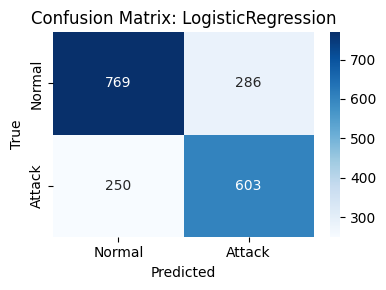

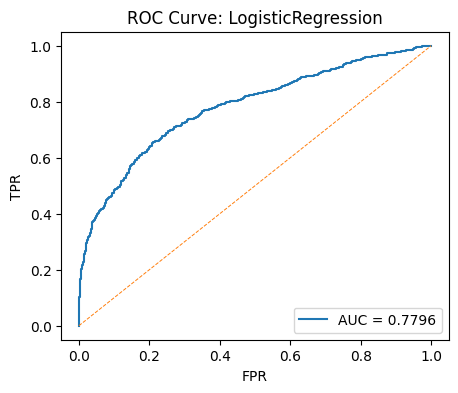

AUC: 0.7796391881455471
Training DecisionTree
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1055
           1       0.79      0.80      0.80       853

    accuracy                           0.82      1908
   macro avg       0.81      0.82      0.81      1908
weighted avg       0.82      0.82      0.82      1908



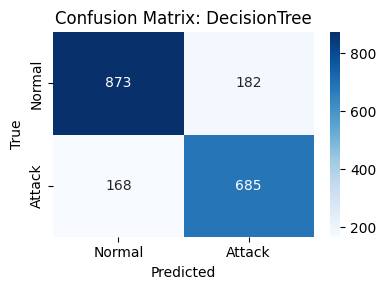

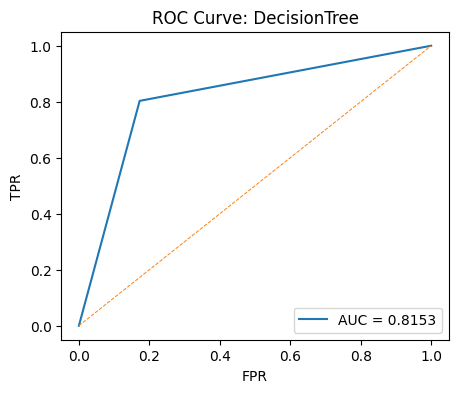

AUC: 0.8152681086547063
Training RandomForest
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1055
           1       1.00      0.75      0.85       853

    accuracy                           0.89      1908
   macro avg       0.91      0.87      0.88      1908
weighted avg       0.90      0.89      0.88      1908



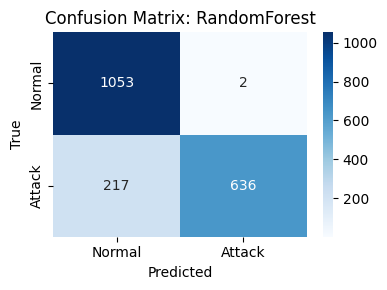

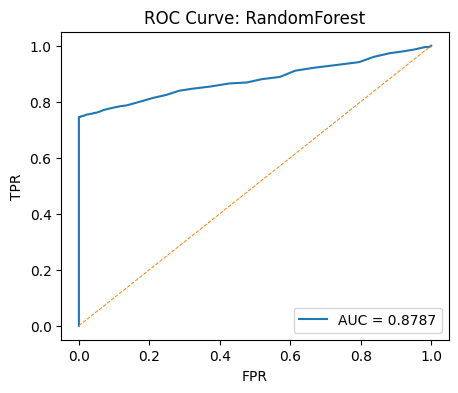

AUC: 0.878710211519977
Training SVM
              precision    recall  f1-score   support

           0       0.83      0.95      0.88      1055
           1       0.92      0.75      0.83       853

    accuracy                           0.86      1908
   macro avg       0.87      0.85      0.85      1908
weighted avg       0.87      0.86      0.86      1908



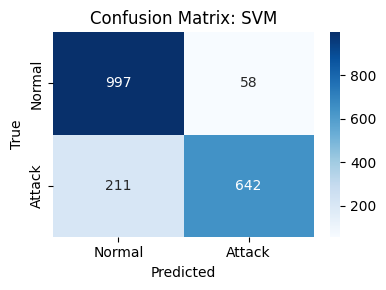

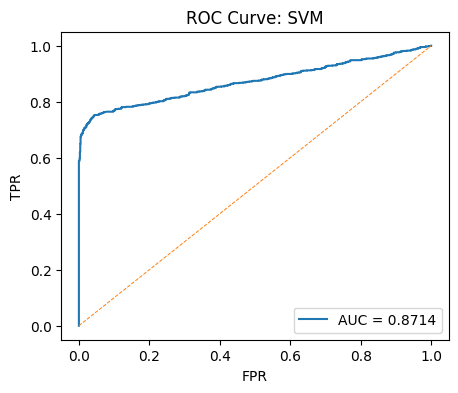

AUC: 0.8713789635687814
Baseline training complete. Plots saved to /content/plots


In [ ]:
#Cell 7: Train baseline models and save plots


models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'DecisionTree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'SVM': SVC(probability=True, class_weight='balanced', random_state=42)
}


results = {}
for name, mdl in models.items():
    print('Training', name)
    # Determine which data to use for fitting based on the model type
    if name in ['SVM', 'LogisticRegression']:
        mdl.fit(X_train_scaled, y_train)
        X_eval = X_test_scaled
    else:
        mdl.fit(X_train, y_train)
        X_eval = X_test

    # Prediction and Classification Report
    y_pred = mdl.predict(X_eval)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = report
    print(classification_report(y_test, y_pred))


    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Attack'], yticklabels=['Normal','Attack'])
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    cm_path = os.path.join(PLOTS_DIR, f'confusion_{name.lower()}.png')
    plt.savefig(cm_path)
    plt.show()


    # ROC / AUC if available
    try:
        if hasattr(mdl, 'predict_proba'):
            probs = mdl.predict_proba(X_eval)[:,1]
        else:
            probs = mdl.decision_function(X_eval)
        fpr, tpr, _ = roc_curve(y_test, probs)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
        plt.plot([0,1],[0,1],'--', linewidth=0.7)
        plt.title(f'ROC Curve: {name}')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.legend(loc='lower right')
        roc_path = os.path.join(PLOTS_DIR, f'roc_{name.lower()}.png')
        plt.savefig(roc_path)
        plt.show()
        print('AUC:', roc_auc)
    except Exception as e:
        print('ROC not available for', name, e)


print('Baseline training complete. Plots saved to', PLOTS_DIR)

In [10]:
# Replace Cell 8 with this (small GridSearch only on RF)
from sklearn.model_selection import GridSearchCV
import time

rf_param_grid_small = {
    'n_estimators': [50],
    'max_depth': [None, 10],
    'min_samples_split': [2]
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_grid_small = GridSearchCV(rf, rf_param_grid_small, cv=3, scoring='f1', n_jobs=-1, verbose=2)
t0 = time.time()
rf_grid_small.fit(X_train, y_train)
print('Best RF params (small grid):', rf_grid_small.best_params_)
print('Best RF CV f1:', rf_grid_small.best_score_)
print('Time (s):', time.time()-t0)

# Save model
import pickle
with open('/content/best_rf_smallgrid.pkl','wb') as f:
    pickle.dump({'rf_grid': rf_grid_small, 'scaler': scaler, 'features': X.columns.tolist()}, f)
print('Saved small-grid RF to /content/best_rf_smallgrid.pkl')


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best RF params (small grid): {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Best RF CV f1: 0.8690469453777738
Time (s): 11.852492570877075
Saved small-grid RF to /content/best_rf_smallgrid.pkl
